In [43]:
###############################
##### inference with out of box model
###############################
import requests
from PIL import Image

from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel

# load a fine-tuned image captioning model and corresponding tokenizer and image processor
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# let's perform inference on an image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_path = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/val/01_4A799364-FADA-4722-BC9C-59D4C913B168.jpeg'

image = Image.open(image_path)
pixel_values = image_processor(image, return_tensors="pt").pixel_values

# autoregressively generate caption (uses greedy decoding by default)
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a large building with a lot of trucks parked in it 


In [42]:
from transformers import ViTImageProcessor, BertTokenizer, VisionEncoderDecoderModel

image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k", "google-bert/bert-base-uncased"
)
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id


/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertLMHeadModel were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossatten

In [41]:
#################################
###Initialize Dataset 
#################################

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import VisionTextDualEncoderModel, VisionTextDualEncoderProcessor, AdamW, DataCollatorWithPadding
from torch.optim import Adam
from torch.nn import functional as F
import torch
import random

# Mapping from class ID to class name
class_names = {
    0: 'DUMPSTER', 1: 'VEHICLE', 2: 'SKID_STEER', 3: 'EXCAVATOR', 4: 'VAN',
    5: 'LUMBER_BUNDLE', 6: 'CONE', 7: 'TRUCK', 8: 'GARBAGE_CONTAINER',
    9: 'LADDER', 10: 'POWER_GENERATOR', 11: 'TELESCOPIC_HANDLER',
    12: 'CONCRETE_BUCKET', 13: 'BOOMLIFT', 14: 'PLYWOOD', 15: 'TOILET_CABIN',
    16: 'FORMWORK_PROP_BUNDLE', 17: 'CONDUIT_ROLL', 18: 'FORMWORK_PANEL',
    19: 'CONCRETE_COLUMN', 20: 'PLATE_COMPACTOR', 21: 'TROWEL_POWER',
    22: 'SLAB_SLEEVES', 23: 'MINI_EXCAVATOR', 24: 'CONTAINER', 25: 'SCISSORLIFT',
    26: 'PICKUP_TRUCK', 27: 'MOBILE_CRANE', 28: 'EQUIPMENT', 29: 'TIEBACK_RIG',
    30: 'TOWER_CRANE', 31: 'CONCRETE_PUMP', 32: 'DRILLRIG', 33: 'LOADER',
    34: 'OFFICE_TRAILER', 35: 'DOZER', 36: 'BUS', 37: 'ROLLER', 38: 'CONCRETE_RIDE',
    39: 'BACKHOE_LOADER', 40: 'FORKLIFT', 41: 'GRADER', 42: 'HAND_ROLLER',
    43: 'HOIST_CABIN'
}

class CustomImageTextDataset(Dataset):
    def __init__(self, image_dir, text_dir):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.jpeg')]
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        text_filename = os.path.splitext(image_filename)[0] + '.txt'
        text_path = os.path.join(self.text_dir, text_filename)

        image = Image.open(image_path).convert('RGB')
        
        
        # Load and parse annotations
        with open(text_path, 'r') as file:
            annotations = file.readlines()
        
        parsed_annotations = [list(map(float, line.strip().split())) for line in annotations]
        # Find the annotation with the largest area
        correct_caption = "an image of unknown"
        if len(parsed_annotations) > 0:
            parsed_annotations.sort(key=lambda x: x[3] * x[4], reverse=True)
            top_annotations = parsed_annotations[:4]
            caption_indices = [int(ann[0]) for ann in top_annotations]
            correct_captions = [class_names[idx] for idx in caption_indices]
            correct_caption = ' '.join(correct_captions)
            correct_caption = f"an image of {correct_caption}"

        pixel_values = image_processor(images=image, return_tensors='pt').pixel_values.squeeze()
        labels = tokenizer(correct_caption, return_tensors='pt').input_ids.squeeze()
        return {'pixel_values': pixel_values, 'labels': labels, 'image_path': image_path}

image_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train'
text_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/labels/train'

train_dataset = CustomImageTextDataset(image_dir=image_dir, text_dir=text_dir)

from torch.utils.data import DataLoader


def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = [item['labels'] for item in batch]
    labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)

    return {
        'pixel_values': pixel_values,
        'labels': labels_padded
    }

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# # Example of iterating through the dataset
for batch in train_dataloader:
    print(batch)
    break

{'pixel_values': tensor([[[[ 0.1373,  0.4510,  0.4824,  ..., -0.1373, -0.2706, -0.3490],
          [-0.0196,  0.2471,  0.3961,  ...,  0.0902,  0.0039, -0.1137],
          [ 0.1843,  0.2549,  0.2863,  ...,  0.0588,  0.0118, -0.2157],
          ...,
          [ 0.4353,  0.3882,  0.4431,  ...,  0.5451,  0.8275,  0.9608],
          [ 0.1843,  0.2157,  0.2471,  ...,  0.8588,  0.9686,  0.9686],
          [ 0.4039,  0.3961,  0.3882,  ...,  0.9216,  0.9451,  0.9294]],

         [[-0.1529,  0.2235,  0.1922,  ...,  0.0353,  0.0353, -0.0196],
          [-0.2471,  0.0275,  0.1294,  ...,  0.1373,  0.0667, -0.0588],
          [-0.0588,  0.0275,  0.0353,  ...,  0.1059,  0.0431, -0.1922],
          ...,
          [ 0.2784,  0.2078,  0.2863,  ...,  0.2863,  0.6784,  0.9059],
          [ 0.1137,  0.1451,  0.1843,  ...,  0.7255,  0.8824,  0.9216],
          [ 0.3333,  0.3176,  0.3020,  ...,  0.8353,  0.8588,  0.8431]],

         [[-0.3804, -0.0431, -0.0510,  ..., -0.0196, -0.0431, -0.0980],
          [-0

In [44]:
from tqdm import tqdm

model.train()

# Training loop
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch + 1} loss: {epoch_loss / len(train_dataloader)}")

# Save the model


/home/jrajan/micromamba/envs/visiondual/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275/1275 [07:58<00:00,  2.66it/s]


Epoch 1 loss: 0.45674218063845357
Epoch 2/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275/1275 [07:30<00:00,  2.83it/s]


Epoch 2 loss: 0.3173633717438754
Epoch 3/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275/1275 [07:29<00:00,  2.83it/s]


Epoch 3 loss: 0.27593187068607294
Epoch 4/4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1275/1275 [07:30<00:00,  2.83it/s]

Epoch 4 loss: 0.23818108209792305


In [45]:
model.save_pretrained('vision_encoder_decoder/model')
image_processor.save_pretrained('vision_encoder_decoder/feature_extractor')
tokenizer.save_pretrained('vision_encoder_decoder/tokenizer')

('vision_encoder_decoder/tokenizer/tokenizer_config.json',
 'vision_encoder_decoder/tokenizer/special_tokens_map.json',
 'vision_encoder_decoder/tokenizer/vocab.json',
 'vision_encoder_decoder/tokenizer/merges.txt',
 'vision_encoder_decoder/tokenizer/added_tokens.json',
 'vision_encoder_decoder/tokenizer/tokenizer.json')

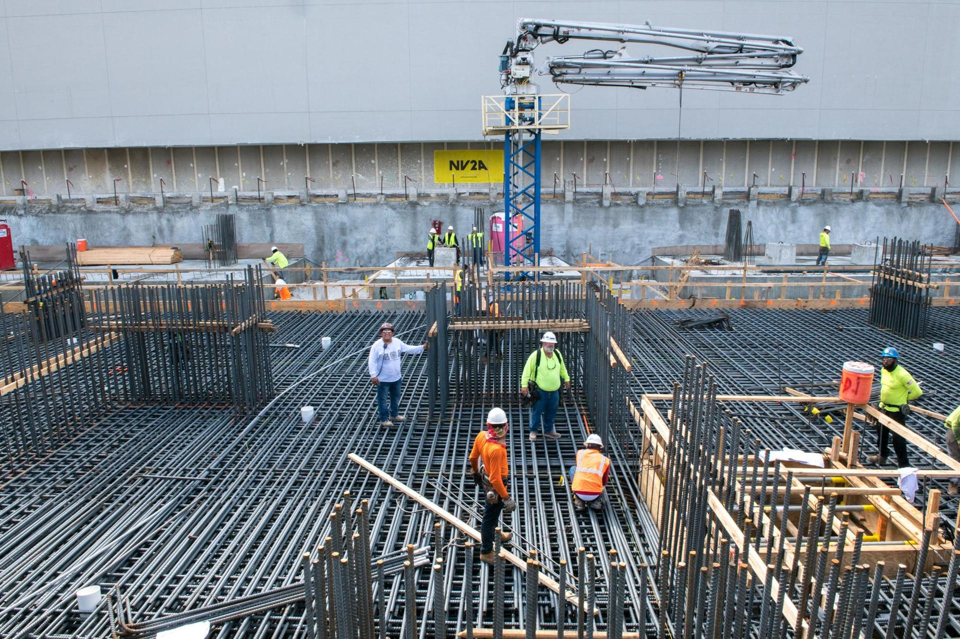

In [39]:
#################################
### Single Image
#################################
import requests
from PIL import Image 

image_path = "/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train/01_001--Optima--09-02-2018-0631.jpg"
#image_path = "/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train/01_001--Optima--14-11-2017-5846.jpg"
#image_path = "/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train/01_002AFA69-A930-41C6-8982-20000E50EF97.jpeg"
#image_path = "/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/train/01_003--Optima--12-08-2017.jpg"

image = Image.open(image_path).convert('RGB')
smaller_image = image.resize((int(image.width / 2), int(image.height / 2)))

# Display the smaller image
display(smaller_image)

In [ ]:
########################################
###Inference with trained model 
########################################
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image



from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
import torch
from PIL import Image

# Load the model, feature extractor, and tokenizer
model = VisionEncoderDecoderModel.from_pretrained("vision_encoder_decoder/model")
feature_extractor = ViTFeatureExtractor.from_pretrained("vision_encoder_decoder/feature_extractor")
tokenizer = AutoTokenizer.from_pretrained("vision_encoder_decoder/tokenizer")


def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    pixel_values = image_processor(images=image, return_tensors='pt').pixel_values
    return pixel_values

def generate_caption(pixel_values, model, tokenizer, max_length=64, num_beams=4):
    # Generate text
    output_ids = model.generate(pixel_values, max_length=max_length, num_beams=num_beams)
    # Decode the output ids to text
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return caption

pixel_values = image_processor(image, return_tensors="pt").pixel_values

# autoregressively generate caption (uses greedy decoding by default)
generated_ids = model.generate(pixel_values)

# pixel_values = preprocess_image(image_path).to(device)

# # Generate caption for the image
# caption = generate_caption(pixel_values, model, tokenizer)
# print("Generated Caption:", caption)



In [ ]:
#################################
### Calculate Accuracy
#################################
from tqdm.notebook import tqdm

image_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/images/val'
text_dir = '/mnt/data/ypatel/ObjectDetection/Dataset/Dataset_D8/labels/val'

val_dataset = CustomImageTextDataset(image_dir=image_dir, text_dir=text_dir)

# To use with a DataLoader
from torch.utils.data import DataLoader

matched = 0
total = 200
for i in range(total):
    original_labels = val_dataset[i]["labels"]
    image_path = val_dataset[i]['image_path']
    image = Image.open(image_path)
    
    pixel_values = preprocess_image(image_path).to(device)

    # Generate caption for the image
    caption = generate_caption(pixel_values, model, tokenizer)
    print("Generated Caption:", caption)
    predicted_labels = caption.split()
    
    
    for clazz in predicted_labels:
        if clazz in original_captions: 
            matched += 1
            break
    
    print(f"original: {original_captions} vs predicted {correct_classes}")
    
accuracy = matched/total